In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier


In [22]:
filename = 'setosa-versicolor'

data = pd.read_csv(f'iris_data/{filename}.csv').to_numpy()

X = data[:, 1: -1]
t = data[:, -1]
#iris_setosa will be 1, iris-versicolor will be -1
t[t == 'Iris-setosa'] = 1
t[t == 'Iris-versicolor'] = -1
t = t.astype('float')

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = 0.4, shuffle = True, stratify = t)
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

In [23]:
read_from_files = True

## Tuning parameters for qSVM

In [24]:
B_values = [2, 3, 5, 10]
K_values = [2, 3]
R_values = [0, 1, 3, 5]
gamma_values = [-1] + [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

run = not read_from_files

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func)

    np.save(f'results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'results/QUBO-{filename}-time', times)

## Tuning parameters for kSVM

In [25]:
C_values = [2, 6, 3, 5, 9, 10, 15, 30]
gamma_values = [-1] + [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

run = not read_from_files

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'results/kSVM-{filename}-time', times)

## Get data from files

In [26]:
if read_from_files:
    qSVM_accuracy = np.load(f'results/QUBO-{filename}-accuracy.npy')
    qSVM_auroc = np.load(f'results/QUBO-{filename}-auroc.npy')

    cSVM_accuracy = np.load(f'results/kSVM-{filename}-accuracy.npy')
    cSVM_auroc = np.load(f'results/kSVM-{filename}-auroc.npy')

In [42]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 2, 4, 7), (8, 7))

## cSVM performance

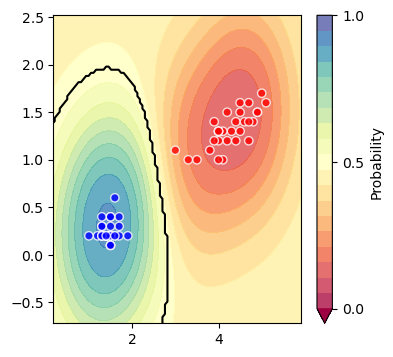

In [27]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [2, 3]
clf = SoftMarginKernelClassifier(2, kernel_func, 1)
clf = clf.fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, colorbar = True)

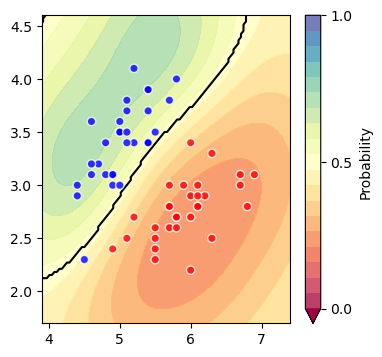

In [49]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = SoftMarginKernelClassifier(2, kernel_func, 1)
clf = clf.fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
c_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, colorbar = True)

## qSVM performance

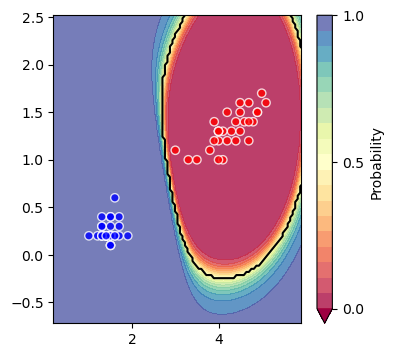

In [50]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [2, 3]
clf = QUBOSoftMarginClassifier(2, 3, 5, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, colorbar = True)

### Probability distribution of the models

(0.0, 1.0)

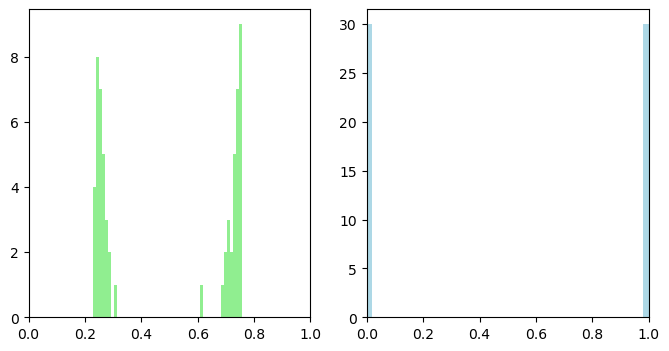

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].hist(c_prob_dist, label = 'cSVM probability distribution', color = 'lightgreen', bins = 50)
ax[1].hist(q_prob_dist, label = 'qSVM probability distribution', color = 'lightblue', bins = 50)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

### Does R make any difference?
R is axis 2 in the results matrices

In [46]:
#We're expecting 56 data points corresponding the the variance as R varies over the other hyper-parameters.
acc_R_var = np.var(qSVM_accuracy, axis = 2)
auc_R_var = np.var(qSVM_auroc, axis = 2)
max(acc_R_var.flatten()), max(auc_R_var.flatten())

(0.02331249999999999, 0.0)

## C, R, and Gamma

In [30]:
C_values = np.zeros((len(B_values), len(K_values)))

for i, B in enumerate(B_values):
    for j, K in enumerate(K_values):
       C_values[i, j] = np.sum([B ** k for k in range(K)])
C_values = C_values.flatten()
C_values

array([  3.,   7.,   4.,  13.,   6.,  31.,  11., 111.])

In [31]:
C_qSVM_accuracy = np.array([qSVM_accuracy[i, j, :, :] for i in range(len(B_values)) for j in range(len(K_values))])

In [32]:
print(np.unravel_index(np.argmax(qSVM_accuracy), qSVM_accuracy.shape))
print(B_values[0], K_values[1], R_values[0], gamma_values[1])

(0, 1, 0, 1)
2 3 0 0.125
